In [98]:
import torch
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.optim as optim
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize

In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

text: a string feature representing the tweet.
label: a classification label with the following values:
0: sadness
1: joy
2: love
3: anger
4: fear
5: surprise

In [27]:
# Read the Parquet file
file_path = "train-00000-of-00001.parquet"  # Replace with your Parquet file path
df = pd.read_parquet(file_path)

# Inspect the DataFrame
df

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2
...,...,...
416804,that was what i felt when i was finally accept...,1
416805,i take every day as it comes i m just focussin...,4
416806,i just suddenly feel that everything was fake,0
416807,im feeling more eager than ever to claw back w...,1


# Data Exploration

In [28]:
# Count samples for each label
label_counts = df['label'].value_counts()
print("Number of samples per label:")
print(label_counts)

Number of samples per label:
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: label, dtype: int64


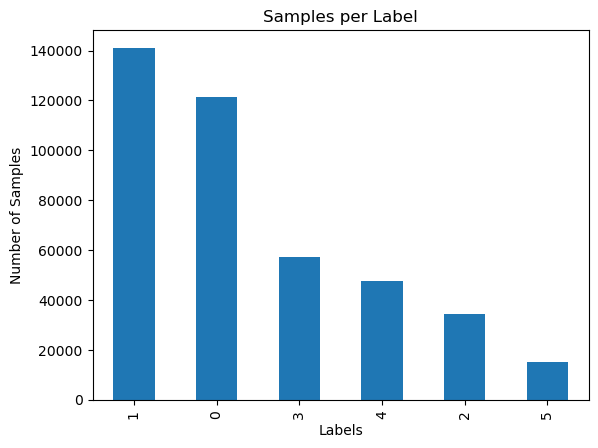

In [29]:
label_counts.plot(kind='bar')
plt.title("Samples per Label")
plt.xlabel("Labels")
plt.ylabel("Number of Samples")
plt.show()

In [30]:
# Determine the minority class size
minority_class_size = label_counts.min()
print(f"Minority class size: {minority_class_size}")

Minority class size: 14972


In [31]:
# Group by the category and sample the minority class size for each group
balanced_df = (
    df.groupby('label')
    .apply(lambda x: x.sample(n=minority_class_size, random_state=42))  # Randomly select samples
    .reset_index(drop=True)  # Reset the index
)

print("Class distribution after undersampling:")
print(balanced_df['label'].value_counts())

Class distribution after undersampling:
0    14972
1    14972
2    14972
3    14972
4    14972
5    14972
Name: label, dtype: int64


In [32]:
balanced_df

,text,label
0,i feel sorry about you because your point of v...,0
1,i feel like he s watching quietly because he s...,0
2,i feel im ugly ugly ugly and ugly now,0
3,i remember my shower and the drawn out manner ...,0
4,i feel unwelcome when we can t go inside right...,0
...,...,...
89827,i feel amazing posted on a href http www,5
89828,i gotta feeling and oprah was not only shocked...,5
89829,i feel amazed as i watch these photos and foot...,5
89830,i am asked early in the morning through an int...,5


In [33]:
# Function to calculate word count
balanced_df['word_count'] = balanced_df['text'].apply(lambda x: len(str(x).split()))
balanced_df

,text,label,word_count
0,i feel sorry about you because your point of v...,0,20
1,i feel like he s watching quietly because he s...,0,31
2,i feel im ugly ugly ugly and ugly now,0,9
3,i remember my shower and the drawn out manner ...,0,30
4,i feel unwelcome when we can t go inside right...,0,15
...,...,...,...
89827,i feel amazing posted on a href http www,5,9
89828,i gotta feeling and oprah was not only shocked...,5,12
89829,i feel amazed as i watch these photos and foot...,5,38
89830,i am asked early in the morning through an int...,5,43


In [34]:
# Calculate statistics
min_words = balanced_df['word_count'].min()
max_words = balanced_df['word_count'].max()
avg_words = balanced_df['word_count'].mean()

print(f"Minimum words: {min_words}")
print(f"Maximum words: {max_words}")
print(f"Average words: {avg_words:.2f}")

Minimum words: 1
Maximum words: 100
Average words: 19.44


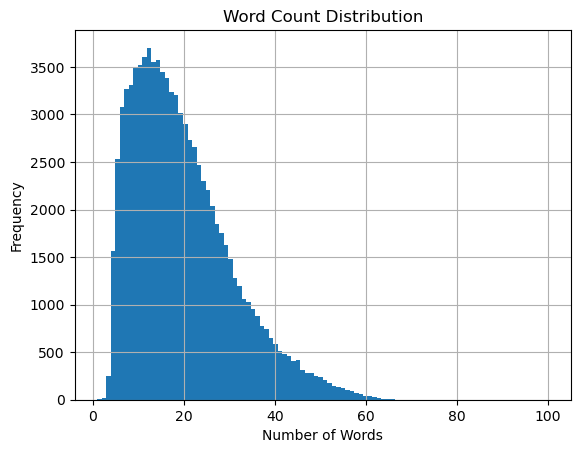

In [36]:
balanced_df['word_count'].hist(bins=100)
plt.title("Word Count Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [37]:
# Create Bag of Words representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(balanced_df['text'])  # Features
y = balanced_df['label']  # Labels

X

<89832x36275 sparse matrix of type '<class 'numpy.int64'>'
	with 1419944 stored elements in Compressed Sparse Row format>

In [38]:
print(vectorizer.get_feature_names_out()[10:100])  # List (some) of words in the vocabulary

['aaron' 'aarons' 'aarthi' 'aate' 'aatp' 'ab' 'aback' 'abad' 'abandon'
 'abandoned' 'abandoning' 'abandonment' 'abashed' 'abate' 'abaya' 'abba'
 'abbasi' 'abbey' 'abbigail' 'abbott' 'abby' 'abc' 'abcesses' 'abd'
 'abdomen' 'abdominal' 'abduct' 'abducted' 'abdul' 'abe' 'abed' 'abefc'
 'abel' 'abercrombie' 'abhay' 'abhorr' 'abhorred' 'abhorrent' 'abi'
 'abide' 'abides' 'abiding' 'abigail' 'abililty' 'abilities' 'ability'
 'abilty' 'abit' 'abject' 'ablaze' 'able' 'ableness' 'ablity' 'ablo'
 'ably' 'abnormal' 'abnormality' 'abnormally' 'abo' 'aboard' 'abocs'
 'abode' 'abolish' 'abolitionist' 'abominable' 'aboriginal'
 'aboriginality' 'aboriginals' 'aborted' 'abortion' 'abotu' 'abou'
 'abound' 'abounding' 'abour' 'about' 'above' 'abq' 'abraham' 'abrahams'
 'abrams' 'abrasion' 'abrasive' 'abrathat' 'abroad' 'abrupt' 'abruptly'
 'abs' 'abscence' 'absence']


In [39]:
# Get the number of unique words
unique_words = len(vectorizer.vocabulary_)
print(f"Number of unique words: {unique_words}")

Number of unique words: 36275


In [58]:
# Tokenize and find unique words using NLTK
all_tokens = set()
for text in balanced_df['text']:
    tokens = word_tokenize(text.lower())  # Tokenize and normalize case
    all_tokens.update(tokens)

print(f"Number of unique words: {len(all_tokens)}")

Number of unique words: 36297


In [69]:
# converts the data to one string
def all_text(text_df):
    combine = ""
    for l in text_df.text:
        combine += ' '.join(x for x in l.split()) #if len(x) > 3  )
    return combine

In [72]:
# creates a word frequency series
def word_freq(some_df):
    freq = nltk.FreqDist(all_text(some_df).split())
    freq_df = pd.DataFrame({"words" : list(freq.keys()),
                           "count" : list(freq.values())})
    return freq_df.sort_values("count" , ascending= False)

In [73]:
all_freq = word_freq(balanced_df)
all_freq

,words,count
0,i,66222
1,feel,61354
34,and,54200
27,to,49804
46,the,47365
...,...,...
29847,chested,1
29846,aqua,1
7011,runaround,1
7013,survivors,1


In [82]:
sadness_freq = word_freq(balanced_df[balanced_df.label == 0])
joy_freq = word_freq(balanced_df[balanced_df.label == 1])
love_freq = word_freq(balanced_df[balanced_df.label == 2])
anger_freq = word_freq(balanced_df[balanced_df.label == 3])
fear_freq = word_freq(balanced_df[balanced_df.label == 4])
surprise_freq = word_freq(balanced_df[balanced_df.label == 5])

In [88]:
sadness_freq[40:50]

,words,count
54,up,854
124,know,833
37,can,823
12,by,817
91,had,780
116,from,780
115,myself,760
48,out,745
263,if,740
565,being,738


In [89]:
joy_freq[40:50]

,words,count
213,because,905
118,really,901
227,will,851
73,if,805
187,what,759
391,t,757
67,know,753
421,how,732
50,get,731
166,out,712


In [44]:
# create a wordcloud image
def draw_wordcloud(words_df , title , color):
    plt.imshow(WordCloud(background_color = color).fit_words(words_df.set_index("words").to_dict()["count"]))
    plt.title(title)
    plt.axis("off")

In [97]:
colormap = {"white" : "orange" ,
           "black": "blue"}
px.pie(balanced_df , names = "Label" , values = np.ones_like(balanced_df.label) ,color = "Label" , color_discrete_map = colormap , hole= 0.3 )

ValueError: Value of 'names' is not the name of a column in 'data_frame'. Expected one of ['text', 'label', 'word_count'] but received: Label

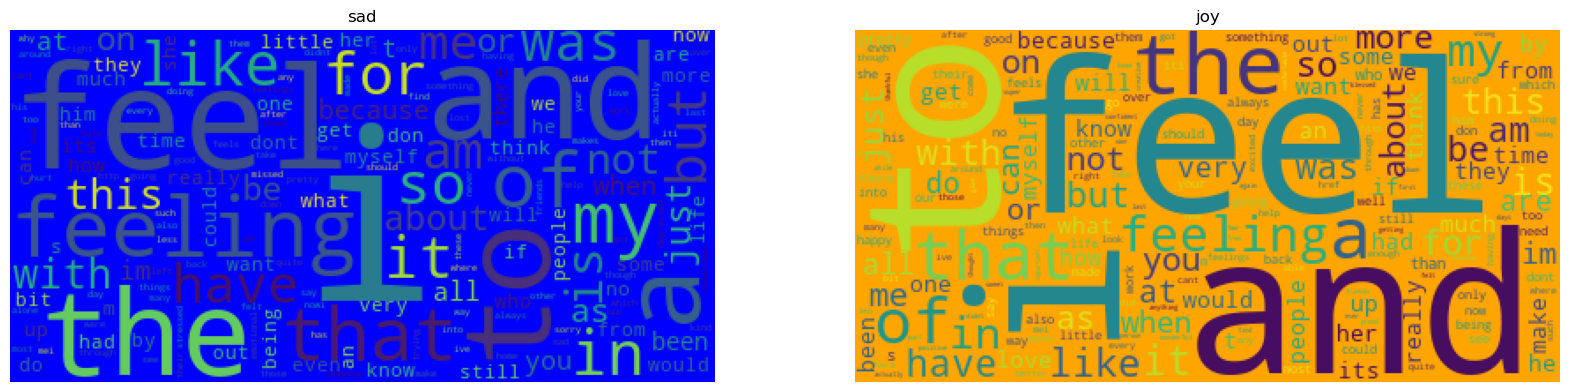

In [100]:
plt.figure(figsize= (20 , 30) ,facecolor='white')
plt.subplot(1, 2 ,1)
draw_wordcloud(sadness_freq , "sad" , "blue")


plt.subplot(1 , 2 , 2)
draw_wordcloud(joy_freq , "joy" , "orange")

plt.show()